In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [2]:
import json

# -----------------------------
# Load constituency-to-state mapping
# -----------------------------
with open("/content/loksabha_constituencies_list.json", "r", encoding="utf-8") as f:
    constituency_map = json.load(f)

constituency_to_state = {}
for state, constituencies in constituency_map.items():
    for c in constituencies:
        constituency_to_state[c.lower()] = state

# -----------------------------
# Load datasets
# -----------------------------
df2009 = pd.read_csv("/content/LokSabha2009_final.csv")
df2014 = pd.read_csv("/content/LokSabha2014_final.csv")
df2019 = pd.read_csv("/content/LokSabha2019_final.csv")



# -----------------------------
# Standardize column names
# -----------------------------
df2009 = df2009.rename(columns={
    "Winner or Not?": "Winner",
    "Constituency": "Constituency",
    "Party": "Party"
})

df2014 = df2014.rename(columns={
    "Name of State/ UT": "State",
    "Party Abbreviation": "Party",
    "Winner or Not?": "Winner",
    "Parliamentary": "Constituency"
})

df2019 = df2019.rename(columns={
    "CONSTITUENCY": "Constituency",
    "PARTY": "Party",
    "WINNER": "Winner"
})



# -----------------------------
# Function to compute state-wise leading party
# -----------------------------
def compute_state_winners(df, year):
    # Normalize Winner column
    if 'Winner' in df.columns:
        df['Winner'] = df['Winner'].apply(lambda x: 1 if str(x).strip().lower() in ['yes', 'winner', '1'] else 0)

    # If no State column, map from constituency
    if 'State' not in df.columns:
        df['State'] = df['Constituency'].str.lower().map(constituency_to_state)

    # Clean up State names
    df['State'] = df['State'].fillna('Unknown')
    df['State'] = df['State'].str.replace('&', 'and', regex=False).str.strip()

    # Filter winners
    winners = df[df['Winner'] == 1] if 'Winner' in df.columns else df

    # Count seats per state and party
    seat_counts = winners.groupby(['State', 'Party']).size().reset_index(name='Seats')

    # Leading party per state
    state_leaders = seat_counts.loc[seat_counts.groupby('State')['Seats'].idxmax()].reset_index(drop=True)
    state_leaders = state_leaders.rename(columns={'Party': 'Leading Party'})
    state_leaders['Year'] = year

    return state_leaders[['State', 'Leading Party', 'Seats', 'Year']]

# -----------------------------
# Compute winners for all years
# -----------------------------
summary_2009 = compute_state_winners(df2009, 2009)
summary_2014 = compute_state_winners(df2014, 2014)
summary_2019 = compute_state_winners(df2019, 2019)

# -----------------------------
# Combine all years
# -----------------------------
all_years = pd.concat([summary_2009, summary_2014, summary_2019], ignore_index=True)
all_years = all_years.sort_values(['State', 'Year']).reset_index(drop=True)

# -----------------------------
# Output
# -----------------------------
yearly_summaries = {
    2009: summary_2009,
    2014: summary_2014,
    2019: summary_2019
}

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)

for year, df in yearly_summaries.items():
    print(f"\n--- Leading Parties in {year} ---")
    print(df.sort_values('State').reset_index(drop=True))

all_years.to_csv("state_wise_winners_all_years.csv", index=False)



--- Leading Parties in 2009 ---
                State Leading Party  Seats  Year
0      Andhra Pradesh           INC     14  2009
1   Arunachal Pradesh           INC      2  2009
2               Assam           INC      6  2009
3               Bihar         JD(U)     11  2009
4          Chandigarh           INC      1  2009
5        Chhattisgarh           BJP      5  2009
6                 Goa           BJP      1  2009
7             Gujarat           BJP      7  2009
8             Haryana           INC      6  2009
9    Himachal Pradesh           BJP      2  2009
10  Jammu and Kashmir           JKN      3  2009
11          Jharkhand           BJP      4  2009
12          Karnataka           BJP     13  2009
13             Kerala           INC      7  2009
14        Lakshadweep           INC      1  2009
15     Madhya Pradesh           BJP     11  2009
16        Maharashtra           INC      9  2009
17            Manipur           INC      2  2009
18          Meghalaya           INC 

In [3]:
import pandas as pd
import json

# -----------------------------
# Load Constituency → State mapping
# -----------------------------
with open("/content/loksabha_constituencies_list.json", "r", encoding="utf-8") as f:
    constituency_map = json.load(f)

constituency_to_state = {}
for state, constituencies in constituency_map.items():
    for c in constituencies:
        constituency_to_state[
            c.strip().lower().replace("&", "and")
        ] = state.strip()

# -----------------------------
# Load 2024 dataset
# -----------------------------
df2024 = pd.read_csv("/content/election_results_2024.csv")

# -----------------------------
# Clean Constituency names in CSV before mapping
# -----------------------------
df2024['Constituency_clean'] = (
    df2024['Constituency']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace('&', 'and', regex=False)
)

# Map constituency → state
df2024['State'] = df2024['Constituency_clean'].map(constituency_to_state)

# Fill missing
df2024['State'] = df2024['State'].fillna('Unknown')

# -----------------------------
# Function to compute state-wise leading party
# -----------------------------
def compute_state_winners(df, year):
    # Count seats per state and party
    seat_counts = df.groupby(['State', 'Leading Party']).size().reset_index(name='Seats')

    # Find party with max seats in each state
    state_leaders = seat_counts.loc[seat_counts.groupby('State')['Seats'].idxmax()].reset_index(drop=True)
    state_leaders['Year'] = year

    return state_leaders[['State', 'Leading Party', 'Seats', 'Year']]

# -----------------------------
# Run for 2024
# -----------------------------
summary_2024 = compute_state_winners(df2024, 2024)

# -----------------------------
# Output
# -----------------------------
print("\n--- Leading Parties in 2024 ---")
print(summary_2024.sort_values('State').reset_index(drop=True))

# Save to CSV
summary_2024.to_csv("state_wise_winners_2024.csv", index=False)



--- Leading Parties in 2024 ---
                          State                 Leading Party  Seats  Year
0   Andaman and Nicobar Islands        Bharatiya Janata Party      1  2024
1                Andhra Pradesh                  Telugu Desam     10  2024
2             Arunachal Pradesh        Bharatiya Janata Party      2  2024
3                         Assam        Bharatiya Janata Party      4  2024
4                         Bihar           Janata Dal (United)     12  2024
5                    Chandigarh      Indian National Congress      1  2024
6                  Chhattisgarh        Bharatiya Janata Party      8  2024
7                 Daman and Diu                   Independent      1  2024
8                           Goa        Bharatiya Janata Party      1  2024
9                       Gujarat        Bharatiya Janata Party     25  2024
10                      Haryana        Bharatiya Janata Party      4  2024
11             Himachal Pradesh        Bharatiya Janata Party      

In [ ]:
# -*- coding: utf-8 -*-
# Election Winner & Seat Prediction (State-wise, for 2024)

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_absolute_error, r2_score

# ------------------------------
# Load dataset
# ------------------------------
df = pd.read_csv("/content/state_wise_winners_all_years.csv")

# ------------------------------
# Feature Engineering
# ------------------------------
df = df.sort_values(by=["State", "Year"]).reset_index(drop=True)

df_feat = df.copy()

# Lag features
df_feat["prev_party"] = df_feat.groupby("State")["Leading Party"].shift(1)
df_feat["prev_seats"] = df_feat.groupby("State")["Seats"].shift(1)
df_feat["prev2_party"] = df_feat.groupby("State")["Leading Party"].shift(2)
df_feat["prev2_seats"] = df_feat.groupby("State")["Seats"].shift(2)

# Extra features
df_feat["seat_change"] = df_feat["Seats"] - df_feat["prev_seats"]
df_feat["incumbency"] = (df_feat["Leading Party"] == df_feat["prev_party"]).astype(int)

# Drop rows with NaN
df_feat = df_feat.dropna().reset_index(drop=True)

# ------------------------------
# Features & Targets
# ------------------------------
cat_features = ["State", "prev_party", "prev2_party"]
num_features = ["prev_seats", "prev2_seats", "seat_change", "incumbency"]

X = df_feat[cat_features + num_features]
y_class = df_feat["Leading Party"]
y_reg   = df_feat["Seats"]

# Preprocessor
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("num", StandardScaler(), num_features)
])

# ------------------------------
# Train-Test Split
# ------------------------------
latest_year = df_feat["Year"].max()   # should be 2019
train = df_feat[df_feat["Year"] < latest_year].copy()
test  = df_feat[df_feat["Year"] == latest_year].copy()

if train.empty:
    train = df_feat.copy()
    test  = df_feat.copy()

X_train, y_class_train, y_reg_train = train[cat_features + num_features], train["Leading Party"], train["Seats"]
X_test,  y_class_test,  y_reg_test  = test[cat_features + num_features],  test["Leading Party"],  test["Seats"]

# Preprocess
X_train_pre = pre.fit_transform(X_train)
X_test_pre  = pre.transform(X_test)

# ------------------------------
# Models
# ------------------------------
rf = RandomForestClassifier(n_estimators=500, random_state=42)
lr = LogisticRegression(max_iter=2000, multi_class="multinomial")

ensemble_clf = VotingClassifier(
    estimators=[("rf", rf), ("lr", lr)],
    voting="soft"
)

rf_reg = RandomForestRegressor(n_estimators=500, random_state=42)

# ------------------------------
# Train
# ------------------------------
ensemble_clf.fit(X_train_pre, y_class_train)
rf_reg.fit(X_train_pre, y_reg_train)

# ------------------------------
# Evaluate
# ------------------------------
y_class_pred = ensemble_clf.predict(X_test_pre)
y_reg_pred   = rf_reg.predict(X_test_pre)

print("=== Classification Report (Party Prediction) ===")
print(classification_report(y_class_test, y_class_pred))

print("\n=== Regression Report (Seats Prediction) ===")
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred))
print("R² :", r2_score(y_reg_test, y_reg_pred))

# ------------------------------
# Predict 2024
# ------------------------------
df_2024 = df_feat[df_feat["Year"] == latest_year].copy()
df_2024["Year"] = 2024

X_2024 = df_2024[cat_features + num_features]
X_2024_pre = pre.transform(X_2024)

df_2024["Predicted Party"] = ensemble_clf.predict(X_2024_pre)
df_2024["Predicted Seats"] = rf_reg.predict(X_2024_pre).round().astype(int)

# ------------------------------
# Final Results
# ------------------------------
print("\n=== 2024 State-wise Predictions ===")
print(df_2024[["State", "Predicted Party", "Predicted Seats"]])

# Save
df_2024[["State", "Predicted Party", "Predicted Seats"]].to_csv("predicted_2024_results.csv", index=False)
print("\n✅ Results saved to predicted_2024_results.csv")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Classification Report (Party Prediction) ===
              precision    recall  f1-score   support

        AITC       1.00      1.00      1.00         1
         BJD       1.00      1.00      1.00         1
         BJP       1.00      1.00      1.00        19
         DMK       1.00      1.00      1.00         1
         INC       1.00      1.00      1.00         3
         MNF       1.00      1.00      1.00         1
         NCP       1.00      1.00      1.00         1
         SKM       1.00      1.00      1.00         1
       YSRCP       1.00      1.00      1.00         1

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29


=== Regression Report (Seats Prediction) ===
MAE: 1.2957931034482755
R² : 0.9456980075694112

=== 2024 State-wise Predictions ===
                State Predicted Party  Predicted Seats
0      Andhra Pradesh           YSRCP               20
1   A

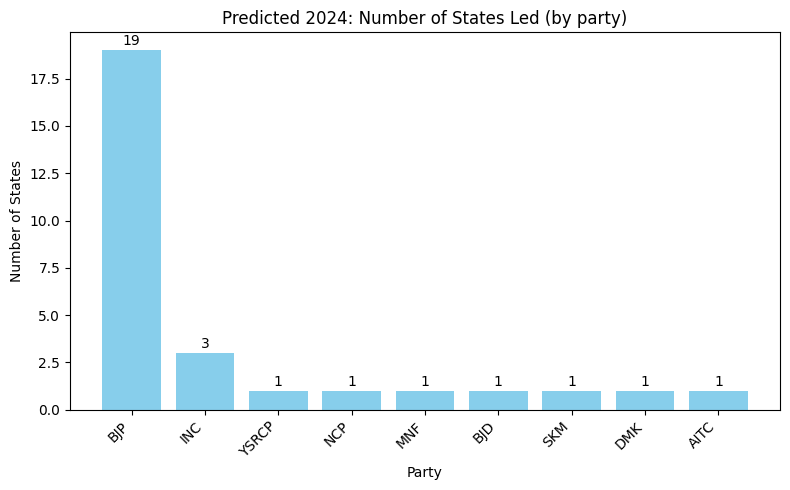

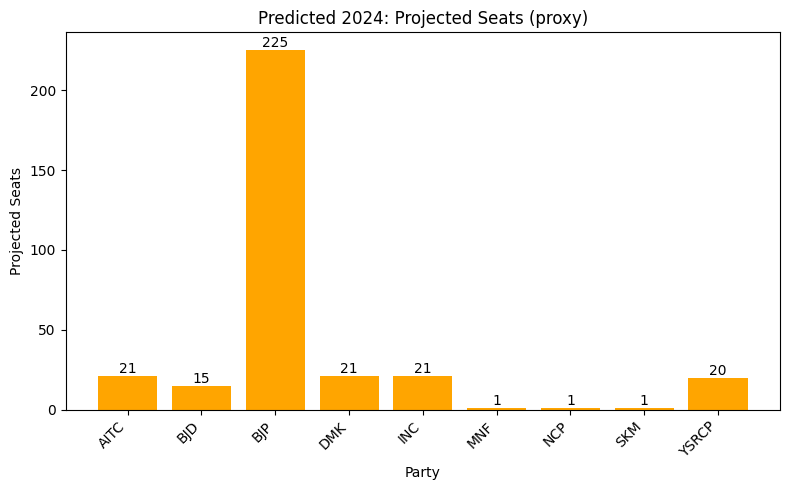

In [5]:
t_states = df_2024["Predicted Party"].value_counts()
t_seats = df_2024.groupby("Predicted Party")["Predicted Seats"].sum()


plt.figure(figsize=(8,5))
bars = plt.bar(t_states.index, t_states.values, color='skyblue')
plt.title("Predicted 2024: Number of States Led (by party)")
plt.xlabel("Party")
plt.ylabel("Number of States")
plt.xticks(rotation=45, ha="right")

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ==============================
# Plot: Projected seats
# ==============================
plt.figure(figsize=(8,5))
bars = plt.bar(t_seats.index, t_seats.values, color='orange')
plt.title("Predicted 2024: Projected Seats (proxy)")
plt.xlabel("Party")
plt.ylabel("Projected Seats")
plt.xticks(rotation=45, ha="right")

# Annotate numbers on top
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()

/tmp/ipython-input-981025658.py:8: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  statedf["PartyShort"] = statedf["Leading Party"].replace()


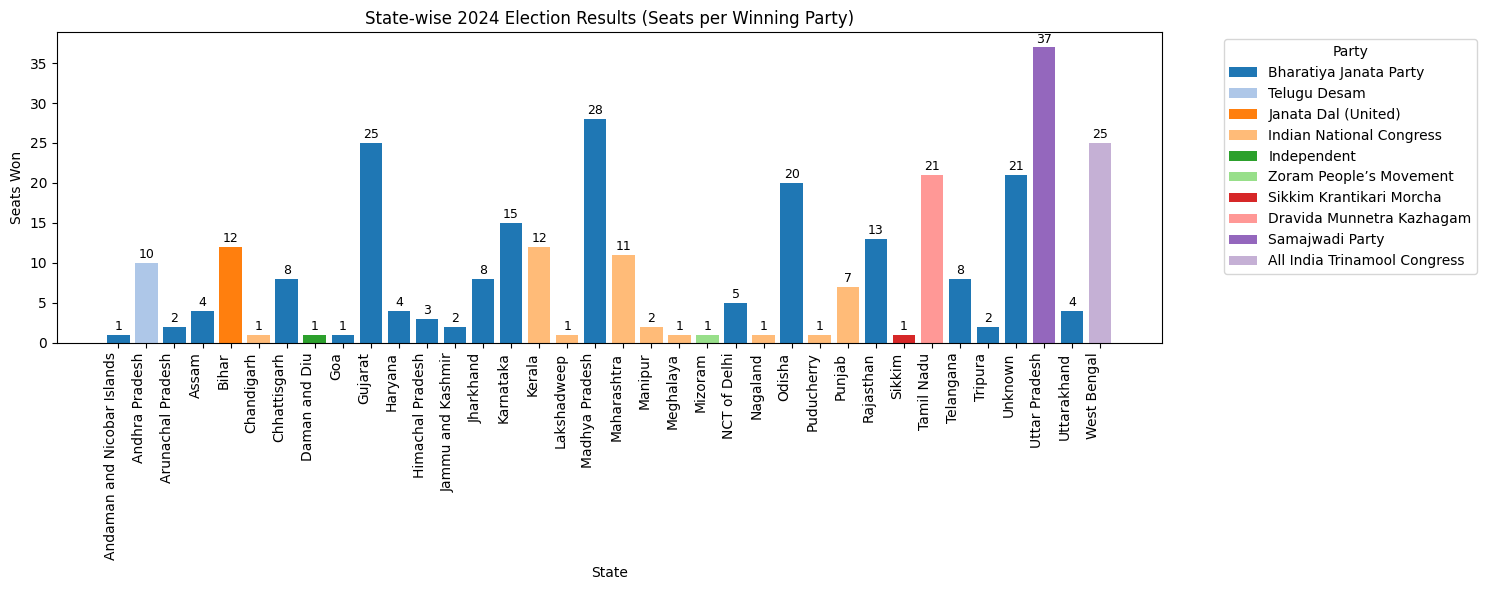

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data
statedf = pd.read_csv("/content/state_wise_winners_2024.csv")

statedf["PartyShort"] = statedf["Leading Party"].replace()

# Sort states alphabetically
statedf = statedf.sort_values("State")

# Assign colors to parties
parties = statedf["PartyShort"].unique()
colors = plt.cm.tab20.colors
party_color_map = {party: colors[i % len(colors)] for i, party in enumerate(parties)}

# Plot
plt.figure(figsize=(15,6))
bars = plt.bar(statedf["State"], statedf["Seats"], color=[party_color_map[p] for p in statedf["PartyShort"]])
plt.title("State-wise 2024 Election Results (Seats per Winning Party)")
plt.xlabel("State")
plt.ylabel("Seats Won")
plt.xticks(rotation=90, ha='right')

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, str(int(height)), ha='center', va='bottom', fontsize=9)

# Add legend
legend_elements = [Patch(facecolor=c, label=p) for p, c in party_color_map.items()]
plt.legend(handles=legend_elements, title="Party", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



In [7]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report

# -----------------------------
# Load datasets
# -----------------------------
actual_df = pd.read_csv("state_wise_winners_2024.csv")
pred_df   = pd.read_csv("/content/predicted_2024_results.csv")

print("Loaded datasets")

# -----------------------------
# Party mapping
# -----------------------------
party_map = {
    "Bharatiya Janata Party": "BJP",
    "Indian National Congress": "INC",
    "All India Trinamool Congress": "AITC",
    "Dravida Munnetra Kazhagam": "DMK",
}

actual_df["Leading Party"] = actual_df["Leading Party"].replace(party_map)
pred_df["Predicted Party"] = pred_df["Predicted Party"].replace(party_map)

# -----------------------------
# Merge predictions with actuals
# -----------------------------
cmp = pred_df.merge(
    actual_df[["State", "Leading Party", "Seats"]],
    on="State", how="inner", suffixes=("_Pred", "_Actual")
)

# -----------------------------
# Filter relevant parties
# -----------------------------
relevant_parties = set(party_map.values())
cmp_filtered = cmp[
    cmp["Leading Party"].isin(relevant_parties) &
    cmp["Predicted Party"].isin(relevant_parties)
].copy()

# # -----------------------------
# # State-level metrics
# # -----------------------------
# cmp_filtered["State_Correct"] = cmp_filtered["Leading Party"] == cmp_filtered["Predicted Leading Party 2024"]

# y_true = cmp_filtered["Leading Party"]
# y_pred = cmp_filtered["Predicted Leading Party 2024"]

# state_acc = accuracy_score(y_true, y_pred)
# f1m_state = f1_score(y_true, y_pred, average="macro")
# f1w_state = f1_score(y_true, y_pred, average="weighted")

# print("\n=== State-level Metrics ===")
# print(f"Accuracy: {state_acc:.3f} | F1-macro: {f1m_state:.3f} | F1-weighted: {f1w_state:.3f}")
# print(classification_report(y_true, y_pred, zero_division=0))

# -----------------------------
# Seat-weighted metrics
# -----------------------------
cmp_filtered["Correct_Seats"] = cmp_filtered.apply(
    lambda row: row["Seats"] if row["Leading Party"] == row["Predicted Party"] else 0,
    axis=1
)

seat_acc = cmp_filtered["Correct_Seats"].sum() / cmp_filtered["Seats"].sum()


y_true_seat = cmp_filtered.loc[cmp_filtered.index.repeat(cmp_filtered["Seats"]), "Leading Party"]
y_pred_seat = cmp_filtered.loc[cmp_filtered.index.repeat(cmp_filtered["Seats"]), "Predicted Party"]

f1m_seat = f1_score(y_true_seat, y_pred_seat, average="macro")
f1w_seat = f1_score(y_true_seat, y_pred_seat, average="weighted")

print("\n=== Seat-weighted Metrics ===")
print(f"Seat Accuracy: {seat_acc:.3f} | F1-macro: {f1m_seat:.3f} | F1-weighted: {f1w_seat:.3f}")
print(classification_report(y_true_seat, y_pred_seat, zero_division=0))



Loaded datasets

=== Seat-weighted Metrics ===
Seat Accuracy: 0.930 | F1-macro: 0.921 | F1-weighted: 0.922
              precision    recall  f1-score   support

        AITC       1.00      1.00      1.00        25
         BJP       0.89      1.00      0.94       119
         DMK       1.00      1.00      1.00        21
         INC       1.00      0.59      0.74        34

    accuracy                           0.93       199
   macro avg       0.97      0.90      0.92       199
weighted avg       0.94      0.93      0.92       199

